In [203]:
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sklearn.metrics as skm
import sklearn.ensemble as ske
%matplotlib inline

In [204]:
data_test = pd.read_csv("../data/prepared_test.csv", sep=";", index_col=0).sort_index()
data_test.head()

,dteday,season,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
7,07.01.2011,1,0,1,0,1,7.86,0.21,74.80,0.17,...,0,0,0,0,0,1,0,0,1,0
11,11.01.2011,1,0,1,0,1,6.76,0.19,102.95,0.12,...,0,0,1,0,0,0,0,0,1,0
14,14.01.2011,1,0,1,0,1,6.43,0.19,80.67,0.13,...,0,0,0,0,0,1,0,1,0,0
16,16.01.2011,1,0,1,0,0,9.27,0.23,72.56,0.19,...,1,0,0,0,0,0,0,1,0,0
18,18.01.2011,1,0,1,0,1,8.67,0.23,129.25,0.15,...,0,0,1,0,0,0,0,0,1,0


In [205]:
data_train = pd.read_csv("../data/prepared_train.csv", sep=";", index_col=0
                         ).sort_index()
data_train.head()

,dteday,season,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
1,01.01.2011,1,0,1,0,0,13.77,0.36,120.87,0.16,...,0,0,0,0,0,0,1,0,1,0
2,02.01.2011,1,0,1,0,0,14.54,0.35,104.41,0.25,...,1,0,0,0,0,0,0,0,1,0
3,03.01.2011,1,0,1,0,1,7.85,0.19,65.59,0.25,...,0,1,0,0,0,0,0,1,0,0
4,04.01.2011,1,0,1,0,1,8.00,0.21,88.57,0.16,...,0,0,1,0,0,0,0,1,0,0
5,05.01.2011,1,0,1,0,1,9.08,0.23,65.54,0.19,...,0,0,0,1,0,0,0,1,0,0


## Initial Model Selection ##

In [206]:
#multicolinear = ["mnth", "temp", "hum", "leaflets"]
multicolinear = ["atemp", "hum", "temp"]

In [207]:
scaler = skp.StandardScaler()

X_train = scaler.fit_transform(X=data_train.drop(
    columns=["dteday", "casual", "registered", "cnt", *multicolinear]))

Y_train = data_train["cnt"].copy()


X_test = scaler.transform(data_test.drop(
    columns=["dteday", "casual", "registered", "cnt", *multicolinear]))

Y_test = data_test["cnt"].copy()

In [208]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, pred = reg.fit(X_train, X_test, Y_train, Y_test)

  2%|▏         | 1/42 [00:00<00:09,  4.43it/s]

 98%|█████████▊| 41/42 [00:04<00:00,  9.97it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 16
[LightGBM] [Info] Start training from score 4455.685811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

100%|██████████| 42/42 [00:05<00:00,  8.03it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [209]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.79,0.82,836.42,0.18
HistGradientBoostingRegressor,0.77,0.80,875.42,1.02
LGBMRegressor,0.77,0.80,878.78,0.23
ExtraTreesRegressor,0.76,0.79,891.39,0.39
RandomForestRegressor,0.75,0.79,905.90,0.58
XGBRegressor,0.75,0.78,907.72,0.13
BaggingRegressor,0.73,0.77,937.75,0.11
DecisionTreeRegressor,0.67,0.71,1047.45,0.02
AdaBoostRegressor,0.63,0.68,1109.24,0.23


In [210]:
def actualVsPredictChart(true_v, pred_v):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

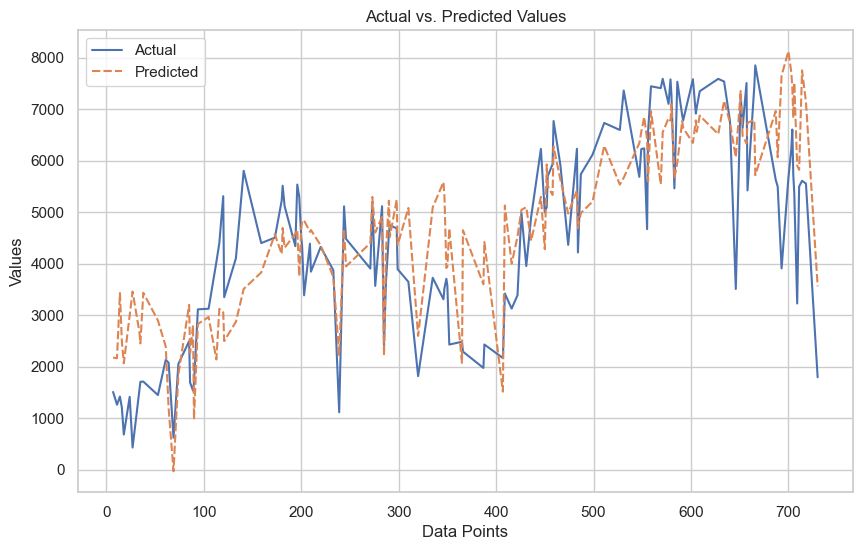

In [211]:
actualVsPredictChart(Y_test, pred["PassiveAggressiveRegressor"].to_numpy())

## Model Tuning ##

In [212]:
def eval_model(scaling_method):


    def eval_model_params(loss, alpha, criterion, learning_rate):


        # Fit Model

        nonlocal X_train, Y_train, X_test, X_train


        model = ske.GradientBoostingRegressor(
            loss=loss, alpha=alpha, criterion=criterion, learning_rate=learning_rate)

        model.fit(X_train, Y_train)


        # Get Model Scores

        sc = model.score(X_train, Y_train)

        y_pred = model.predict(X_test)

        r2 = skm.r2_score(Y_test, y_pred)

        rmse = np.sqrt(skm.mean_squared_error(Y_test, y_pred))

        mae = skm.mean_absolute_error(Y_test, y_pred)


        # Return Values

        return [loss, alpha, criterion, learning_rate, sc, r2, rmse, mae, model, Y_test, y_pred]


    # Data Scaling

    X_train = scaling_method.fit_transform(X=data_train.drop(
        columns=["dteday", "casual", "registered", "cnt"]))

    Y_train = data_train["cnt"].copy()

    X_test = scaling_method.transform(data_test.drop(
        columns=["dteday", "casual", "registered", "cnt"]))

    Y_test = data_test["cnt"].copy()


    # Parameters

    # losses = ['squared_error', 'absolute_error', 'huber', 'quantile']
    losses = ["huber"]
    alphas = [0.2*x for x in range(1, 5)]
    criterions = ['friedman_mse', 'squared_error']
    learning_rates = [0.2*x for x in range(1, 5)]
    params = [losses, alphas, criterions, learning_rates]


    results = pd.DataFrame(
        columns=["scalingmethod", "loss", "alpha", "criterion", "learning_rate", "score", "R squared", "RMSE", "MAE", "model", "ytest", "ypred"])

    all_combinations = list(itertools.product(*params))
    for comb in all_combinations:

        eval_params = eval_model_params(
            loss=comb[0], alpha=comb[1], criterion=comb[2], learning_rate=comb[3])

        results.loc[len(results)] = [repr(scaling_method), *eval_params]
        print(comb, end=" "*15 + "\r")


    return results.sort_values("R squared", ascending=False).iloc[0].copy()

In [213]:
list_scalers = [
    #skp.KBinsDiscretizer,
    #skp.MaxAbsScaler,
    #skp.MinMaxScaler,
    #skp.Normalizer,
    skp.PolynomialFeatures,
    skp.QuantileTransformer,
    #skp.StandardScaler,
    #skp.SplineTransformer,
    skp.PowerTransformer
]

results = pd.DataFrame(columns=["scalingmethod", "loss", "alpha", "criterion",
                       "learning_rate", "score", "R squared", "RMSE", "MAE", "model", "ytest", "ypred"])

for func in list_scalers:
    print(f"Using method: {repr(func)}")
    results.loc[len(results)] = eval_model(scaling_method=func())

Using method: <class 'sklearn.preprocessing._polynomial.PolynomialFeatures'>
Using method: <class 'sklearn.preprocessing._data.QuantileTransformer'>          
Using method: <class 'sklearn.preprocessing._data.PowerTransformer'>             


In [214]:
res_model = results.sort_values("MAE", ascending=True).iloc[0, 9]
res_y_test = results.sort_values("MAE", ascending=True).iloc[0, 10]

res_y_pred = results.sort_values("MAE", ascending=True).iloc[0, 11]

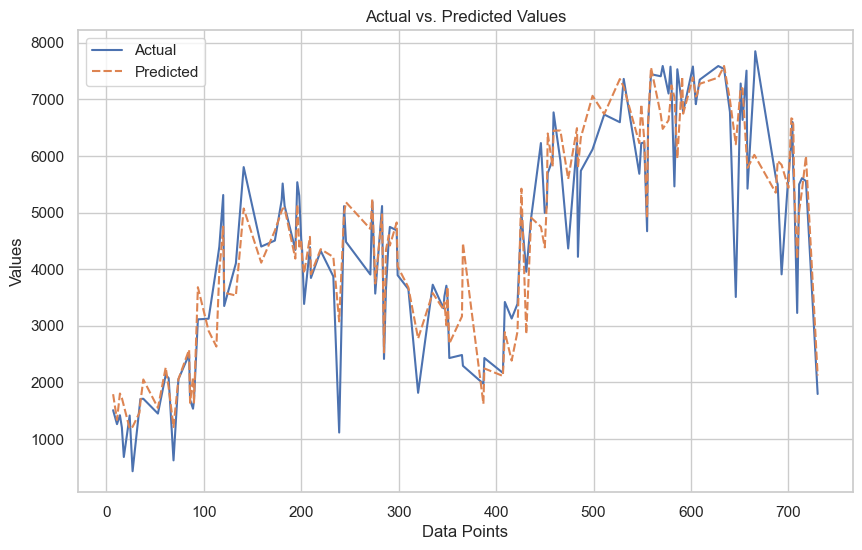

In [215]:
actualVsPredictChart(res_y_test, res_y_pred)

<Axes: xlabel='cnt'>

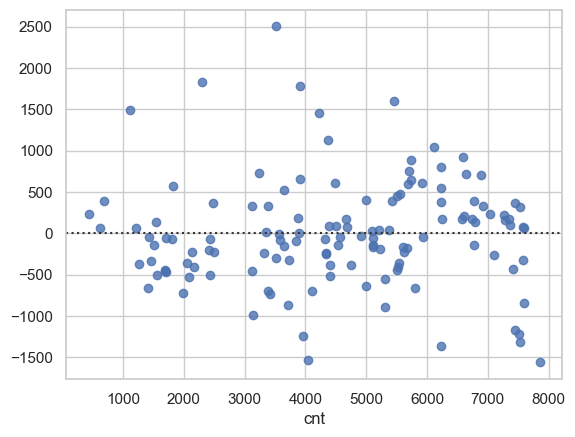

In [216]:
sns.residplot(x=res_y_test, y=res_y_pred)

Das originale Modell hatte einen R² von 0.6 -> 0.88 <br>
MAE war ~802 -> 487

In [217]:
results.iloc[:, :9].sort_values("MAE")

,scalingmethod,loss,alpha,criterion,learning_rate,score,R squared,RMSE,MAE
0,PolynomialFeatures(),huber,0.40,squared_error,0.40,0.97,0.87,693.88,473.71
1,QuantileTransformer(),huber,0.40,squared_error,0.20,0.95,0.88,682.60,486.05
2,PowerTransformer(),huber,0.40,squared_error,0.20,0.95,0.88,689.72,487.98
